### Cleaning insider trading data

In [17]:
import sqlite3
import pandas as pd

In [ ]:
csv_file = 'C:\\Users\\hai74\\Desktop\\lit_nonderiv.csv'
db_file = '../../datasets/insider_trading.db'
table_name = 'nonderiv'

# Set the chunk size (number of rows per chunk, you can adjust this as needed)
chunk_size = 100000  # Adjust depending on memory constraints

# Create a connection to the SQLite database
conn = sqlite3.connect(db_file)

# Use the first chunk to create the table, then append subsequent chunks
for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
    if i == 0:
        # Create table in the first chunk
        chunk.to_sql(table_name, conn, if_exists='replace', index=False)
    else:
        # Append subsequent chunks to the table
        chunk.to_sql(table_name, conn, if_exists='append', index=False)
    
    print(f"Chunk {i + 1} inserted.")


In [ ]:
# add isBuy col
alter_table_query = f"""
ALTER TABLE {table_name}
ADD COLUMN isBuy INTEGER;
"""
try:
    conn.execute(alter_table_query)
    print(f"'isBuy' column successfully added to {table_name}.")
except sqlite3.OperationalError as e:
    if 'duplicate column name' in str(e).lower():
        print("'isBuy' column already exists.")
    else:
        raise  # Raise other errors if they occur

# Update the 'isBuy' column based on 'transactionCode'
update_isBuy_query = f"""
UPDATE {table_name}
SET isBuy = CASE
    WHEN transactionCode IN ('P', 'A', 'M', 'I', 'G', 'L') THEN 1  -- Buy codes
    WHEN transactionCode IN ('S', 'D', 'F', 'W', 'U') THEN 0  -- Sell codes
    ELSE NULL  -- Set to NULL for undefined codes
END;
"""

conn.execute(update_isBuy_query)
conn.commit()  # Commit the changes

'isBuy' column successfully added to nonderiv.


In [ ]:
# query to select filingDate and isBuy where isBuy is not NULL
select_date_and_buy_query = f"""
SELECT transactionDate, isBuy FROM {table_name}
WHERE isBuy IS NOT NULL;
"""

# Execute the query and load the result into a Pandas DataFrame
df = pd.read_sql_query(select_date_and_buy_query, conn)

In [ ]:
df.set_index('transactionDate', inplace=True)

In [ ]:
df.to_csv('../datasets/insider_nonderiv.csv')

In [ ]:
conn.close()

### Transforming buy/sell to daily aggreate insider activities

In [1]:
import pandas as pd

In [36]:
db_file = '../../datasets/insider_trading.db'
conn = sqlite3.connect(db_file)

table_name = 'deriv'
select_date_and_buy_query = f"""
SELECT transactionDate, isBuy FROM {table_name}
WHERE isBuy IS NOT NULL;
"""

deriv = pd.read_sql_query(select_date_and_buy_query, conn)

In [48]:
# clean up datetime string #TODO: consider regex
deriv['transactionDate'] = deriv['transactionDate'].str.strip()
deriv['transactionDate'] = deriv['transactionDate'].str.replace(' ', '')
deriv['transactionDate'] = deriv['transactionDate'].str.replace('--', '-')
deriv['transactionDate'] = deriv['transactionDate'].str.replace('000', '200')

# parse datetime
deriv['transactionDate'] = pd.to_datetime(deriv['transactionDate'], format='%Y-%m-%d', errors='coerce')
deriv.dropna(inplace=True)

# Filter the DataFrame to keep only dates between 2003 and 2024
start_date = pd.to_datetime('2003-01-01')
end_date = pd.to_datetime('2024-12-31')
deriv = deriv[(deriv['transactionDate'] >= start_date) & (deriv['transactionDate'] <= end_date)]

deriv.set_index('transactionDate', inplace=True)
deriv = deriv.sort_index()

In [ ]:
table_name = 'nonderiv'
select_date_and_buy_query = f"""
SELECT transactionDate, isBuy FROM {table_name}
WHERE isBuy IS NOT NULL;
"""

nonderiv = pd.read_sql_query(select_date_and_buy_query, conn)

In [87]:
nonderiv['transactionDate'] = nonderiv['transactionDate'].str.strip()
nonderiv['transactionDate'] = nonderiv['transactionDate'].str.replace(' ', '')
nonderiv['transactionDate'] = nonderiv['transactionDate'].str.replace('--', '-')
nonderiv['transactionDate'] = nonderiv['transactionDate'].str.replace('000', '200')

# parse datetime
nonderiv['transactionDate'] = pd.to_datetime(nonderiv['transactionDate'], format='%Y-%m-%d', errors='coerce')
nonderiv.dropna(inplace=True)

# Filter the DataFrame to keep only dates between 2003 and 2024
start_date = pd.to_datetime('2003-01-01')
end_date = pd.to_datetime('2024-12-31')
nonderiv = nonderiv[(nonderiv['transactionDate'] >= start_date) & (nonderiv['transactionDate'] <= end_date)]

nonderiv.set_index('transactionDate', inplace=True)
nonderiv = nonderiv.sort_index()

### calculate the daily net buy and sale

In [95]:
deriv_grouped = deriv.groupby(deriv.index)

# Calculate the number of buys and total transactions for each day
deriv_daily_stats = deriv_grouped['isBuy'].agg(['sum', 'count']).rename(columns={'sum': 'num_buys', 'count': 'total_transactions'})

# Calculate the number of sales
deriv_daily_stats['num_sales'] = deriv_daily_stats['total_transactions'] - deriv_daily_stats['num_buys']

# Calculate net buys
deriv_daily_stats['net_buys'] = deriv_daily_stats['num_buys'] - deriv_daily_stats['num_sales']

<Axes: xlabel='transactionDate'>

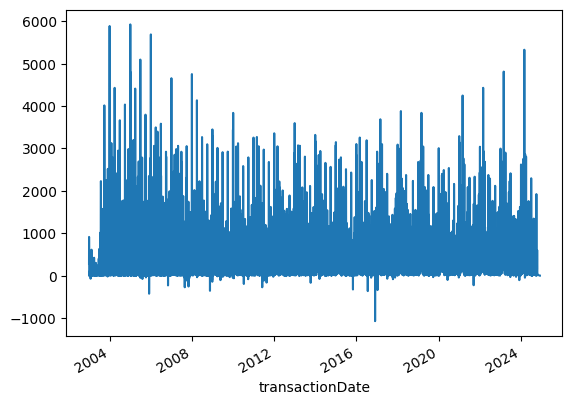

In [97]:
deriv_daily_stats['net_buys'].plot()

Derivative transactions are biased towards buys. We shouldn't incorporate them into the final dataset.

In [101]:
nonderiv_grouped = nonderiv.groupby(nonderiv.index)

# Calculate the number of buys and total transactions for each day
nonderiv_daily_stats = nonderiv_grouped['isBuy'].agg(['sum', 'count']).rename(columns={'sum': 'num_buys', 'count': 'total_transactions'})

# Calculate the number of sales
nonderiv_daily_stats['num_sales'] = nonderiv_daily_stats['total_transactions'] - nonderiv_daily_stats['num_buys']

# Calculate net buys
nonderiv_daily_stats['net_buys'] = nonderiv_daily_stats['num_buys'] - nonderiv_daily_stats['num_sales']

In [114]:
nonderiv_daily_stats.drop(['num_buys','total_transactions', 'num_sales'], axis=1).to_csv('../../datasets/nonderiv_insider_activity.csv')

In [113]:
nonderiv_daily_stats

,num_buys,total_transactions,num_sales,net_buys
transactionDate,,,,
2003-01-01,156,156,0,156
2003-01-02,201,239,38,163
2003-01-03,79,81,2,77
2003-01-04,2,4,2,0
2003-01-05,10,12,2,8
...,...,...,...,...
2024-10-18,39,147,108,-69
2024-10-24,0,2,2,-2
2024-11-23,0,2,2,-2
